## 03.네트워크 분석 활용

- 사용데이터 :

    - Open Street Map 데이터를 API로 참조해서 사용
    - 한국관광공사 관광데이터랩 네비게이션 데이터 활용
    -

- 작성자 : 권도희(epik5064@naver.com)

- 최종수정일 : 2025.12.16

[수정이력]
- 2025.12.15 최초작성

In [44]:
## 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import geopandas as gpd
from typing import Optional, Dict, Any
import time

## 네트워크데이터 가져오기
import osmnx as ox

## 네트워크 분석용
import networkx as nx

## 클러스터링 등 ML 계산용
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import contextily as ctx

## GIS 라이브러리
from shapely.geometry import Point

## api 요청용
import requests
from dotenv import load_dotenv

### 1. 포천시 교통네트워크 기본 분석

#### 1-1. 기본 노드링크 데이터 로드

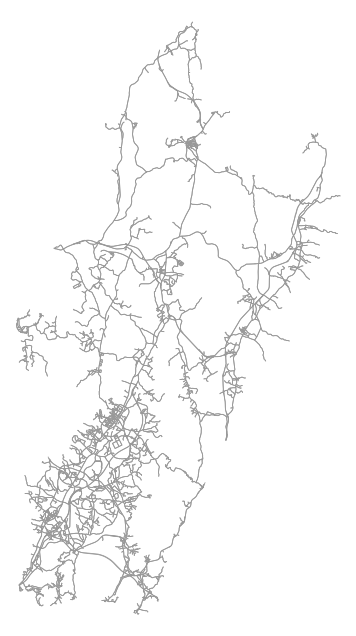

노드 수: 3844
엣지 수: 9128


In [42]:
### 포천시 노드링크 OSMnx

# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Pocheon-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

#### 1-2. 경로강제성 시각화

- 가장 많이 쓰이는 Betweenness Centrality를 활용

In [47]:
# 1) 그래프 가져오기
place_name = "Pocheon-si, South Korea"
G = ox.graph_from_place(place_name, network_type="drive")  # MultiDiGraph

# OSMnx는 기본적으로 edge['length']를 넣어줌 (추가 설정 필요 X)

# 2) edge betweenness 계산용 간단한 undirected 그래프 만들기
#    - parallel edge, 방향성은 일단 무시하고 구조만 보자
Gu = nx.Graph(G)   # MultiDiGraph -> simple Graph

# 3) edge betweenness 계산 (길이 기준)
bw_dict = nx.edge_betweenness_centrality(Gu, normalized=True, weight="length")
# bw_dict: {(u, v): 값}  (u, v)는 undirected라 (u, v) / (v, u) 동일 취급

# 4) 원래 G(MultiDiGraph)의 edge에 값 붙이기
for u, v, k, data in G.edges(keys=True, data=True):
    key = tuple(sorted((u, v)))  # undirected 키
    data["edge_bw"] = bw_dict.get(key, 0.0)

# 5) GeoDataFrame 변환
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# 혹시라도 없는 컬럼 체크 (디버깅용)
print(edges_gdf.columns)
print(edges_gdf["edge_bw"].describe())

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'edge_bw', 'lanes',
       'name', 'geometry', 'ref', 'bridge', 'maxspeed', 'tunnel', 'width',
       'access', 'junction'],
      dtype='object')
count    9128.000000
mean        0.010857
std         0.025578
min         0.000000
25%         0.000520
50%         0.001560
75%         0.007069
max         0.200824
Name: edge_bw, dtype: float64


c:\Users\user\Desktop\AI 및 머신러닝\LLM-Geo-master\LLM-Geo-master\.conda\lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


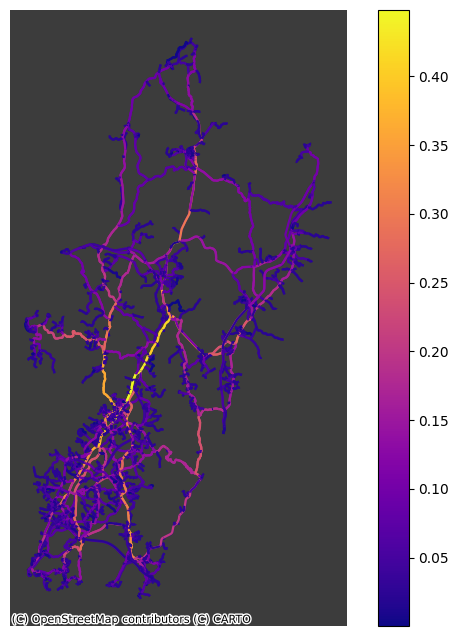

In [48]:
#좌표계 설정
edges_gdf = edges_gdf.to_crs(epsg=4326)
# 시각화를 위해 루트처리
fig.patch.set_facecolor("#9E9999") 
ax.set_facecolor("#111111")          
edges_gdf["bw_sqrt"] = np.sqrt(edges_gdf["edge_bw"])

# 6) 플롯
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# (2) betweenness가 있는 edge만 색칠
edges_gdf.loc[edges_gdf["bw_sqrt"] > 0].plot(
    ax=ax,
    column="bw_sqrt",
    cmap="plasma",
    linewidth=1.6,
    legend=True,
    zorder=2
)
# ✅ 실제 지도 배경
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatter,  # 어두운 배경
    alpha=0.9
)

ax.set_axis_off()
#plt.tight_layout()
plt.show()

중심 간선도로를 많이 지나갈수밖에 없는 형상을 보임

### 2. 관광지 데이터 추가분석

In [11]:
## 포천시 네비게이션 검색 상위 20개 

pocheon_poi = pd.read_csv('./data/포천시네비게이션검색순위_202510.csv')
pocheon_poi = pocheon_poi.head(20)

pocheon_poi

,순위,광역시/도,시/군/구,관광지명,중분류 카테고리,소분류 카테고리,검색건수,도로명주소,지번주소
0,1,경기도,포천시,산정호수,자연관광,자연경관(하천/해양),23711,NaN,경기 포천시 영북면 산정리
1,2,경기도,포천시,한탄강Y자출렁다리,기타관광,기타관광,22999,NaN,경기 포천시 영북면 대화산리 256
2,3,경기도,포천시,국립수목원,문화관광,테마공원,16762,NaN,경기 포천시 소홀읍 작동리 50-18
3,4,경기도,포천시,포천한탄강가든페스타,문화관광,기타문화관광지,15082,경기 포천시 관인면 창동로 832,경기 포천시 관인면 중리 526-1
4,5,경기도,포천시,포천아트밸리,문화관광,공연시설,14788,NaN,경기 포천시 신북면 기지리 282
5,6,경기도,포천시,허브아일랜드,체험관광,농/산/어촌체험,13293,NaN,경기 포천시 신북면 삼정리 517 2
6,7,경기도,포천시,포천힐마루CC,레저스포츠,육상레저스포츠,13131,NaN,경기 포천시 영중면 거사리 105
7,8,경기도,포천시,베어크리크GC,레저스포츠,육상레저스포츠,11791,NaN,경기 포천시 화현면 지현리 2 1
8,9,경기도,포천시,포천힐스CC,레저스포츠,육상레저스포츠,11078,NaN,경기 포천시 군내면 상성북리 34-1
9,10,경기도,포천시,필로스GC,레저스포츠,육상레저스포츠,10756,NaN,경기 포천시 일동면 기산리 142 1


In [35]:
load_dotenv("./.gitignore/vworld_API_KEY.env")
vworld_API_KEY = os.getenv("vworld_API_KEY")
if not vworld_API_KEY:
    raise RuntimeError("환경변수 vworld_API_KEY가 없음.")

def vworld_geocode(query, key=vworld_API_KEY):
    """
    관광지명(키워드)로 장소 검색 → 주소(road_address_name 우선, 없으면 address_name) 추출
    """
    url = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "version": "2.0",
        "crs": "EPSG:4326",
        "address": query,
        "type": "PARCEL",   
        "size": 1,
        "format": "json",
        "key": key,
    }
    r = requests.get(url, params=params, timeout=5).json()
    print(r)
    try:
        p = r["response"]["result"]["point"]
        return float(p["y"]), float(p["x"])  # lat, lon
    except:
        return None, None

# -------------------------
# 사용 예시
# -------------------------

pocheon_poi["lat"], pocheon_poi["lon"] = zip(*pocheon_poi["지번주소"].apply(vworld_geocode))
time.sleep(0.1)

{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '22(ms)'}, 'status': 'OK', 'input': {'type': 'PARCEL', 'address': '경기 포천시 영북면 산정리'}, 'refined': {'text': '경기도 포천시 영북면 산정리 1', 'structure': {'level0': '대한민국', 'level1': '경기도', 'level2': '포천시', 'level3': '', 'level4L': '영북면', 'level4LC': '4165039023100010000', 'level4A': '', 'level4AC': '', 'level5': '1', 'detail': ''}}, 'result': {'crs': 'EPSG:4326', 'point': {'x': '127.35488440203153', 'y': '38.08567618486825'}}}}
{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '21(ms)'}, 'status': 'NOT_FOUND', 'record': {'total': '0', 'current': '0'}, 'page': {'total': '1', 'current': '1', 'size': '10'}}}
{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '25(ms)'}, 'status': 'NOT_FOUND', 'record': {'total': '0', 'current': '0'}, 'page': {'total': '1', 'current': '1', 'size': '10'}}}
{'response': {'service': {'name'

In [39]:
pocheon_poi.to_csv('./data/포천시네비게이션검색순위_202510_processed.csv', encoding='cp949')

api로 검색이 불가능한 경우 직접 처리

In [41]:
## 전처리 완료된 데이터를 다시 불러오기

pocheon_poi = pd.read_csv('./data/포천시네비게이션검색순위_202510_processed.csv', encoding='cp949')

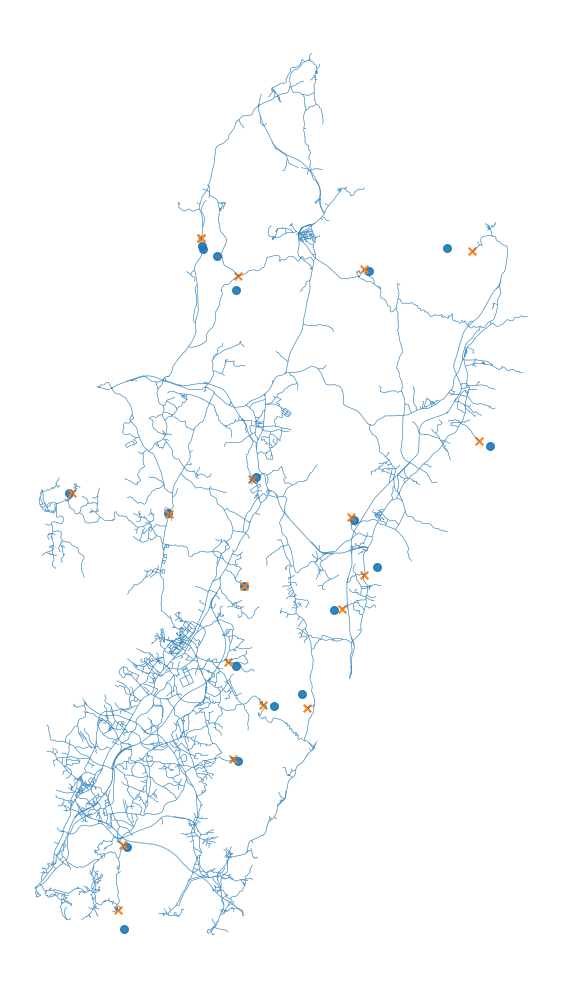

In [45]:
## 관광지별로 가장 가까운 노드를 시각화
# 1) 그래프 → GeoDataFrame
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 2) 관광지 → GeoDataFrame (WGS84)
spots_gdf = gpd.GeoDataFrame(
    pocheon_poi.copy(),
    geometry=gpd.points_from_xy(pocheon_poi["lon"], pocheon_poi["lat"]),
    crs="EPSG:4326"
)

# 3) 관광지별 가장 가까운 노드(osmid) 구하고, 그 노드만 추출
spots_gdf["nearest_node"] = ox.distance.nearest_nodes(
    G, X=spots_gdf.geometry.x, Y=spots_gdf.geometry.y
)
nearest_nodes_gdf = nodes_gdf.loc[spots_gdf["nearest_node"].values].copy()

# 4) 시각화 (WGS84 그대로 그려도 되지만, 보기 좋게 metric으로 투영 권장)
proj_crs = edges_gdf.estimate_utm_crs()
edges_p = edges_gdf.to_crs(proj_crs)
nodes_p = nodes_gdf.to_crs(proj_crs)
spots_p = spots_gdf.to_crs(proj_crs)
near_p = nearest_nodes_gdf.to_crs(proj_crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_p.plot(ax=ax, linewidth=0.4, alpha=0.6)
spots_p.plot(ax=ax, markersize=30, alpha=0.9)        # 관광지 점
near_p.plot(ax=ax, markersize=30, marker="x")        # 가장 가까운 노드 (X)

# (선택) 관광지-최근접노드 연결선
# gpd.GeoSeries(
#     [Point(a).buffer(0).centroid for a in []], crs=proj_crs
# )
# for p, n in zip(spots_p.geometry, near_p.geometry):
#     ax.plot([p.x, n.x], [p.y, n.y], linewidth=0.6, alpha=0.7)

ax.set_axis_off()
plt.tight_layout()
plt.show()